In [11]:
import pandas as pd
import numpy as np

#Plotting libs
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


#Football libs
import socceraction
from socceraction.data.statsbomb import StatsBombLoader
from mplsoccer import Pitch, Sbopen, VerticalPitch
import socceraction.spadl as spadl
import matplotsoccer as mps
import socceraction.xthreat as xthreat
import socceraction.spadl as spadl
from socceraction.vaep import VAEP

# utils
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

TO DO:

0. add a notebook 1 with a single match exploration - this becomes notebook 2 
1. group by zones and add in xT & VAEP Scores 
2. Visualise those 
3. Find top players for each team by xT for their end locations 
4. Calculate the xT difference between the start and end location 
5. EDA into notebook 2 - add in 5 EDA sections
    - zone analysis
    - top players
    - heatmaps for passes/dribbles/crosses and end_zones 
    - distance analysis 

other:
- modify code to add in seasons 1,2 - create season 3 as a separate test dataset 
- find player transfers


## Data Analysis on Training Set

In [44]:
xt_zone_values = mov_actions_with_zones[['end_pitch_zone', 'xT_value']].groupby('end_pitch_zone').mean().reset_index()

In [45]:
vaep_zone_values = df_actions_zones[['end_pitch_zone', 'vaep_value']].groupby('end_pitch_zone').mean().reset_index()

In [46]:
zone_values = pd.concat([vaep_zone_values, xt_zone_values['xT_value']], axis=1)

In [47]:
action_vaep = df_actions_zones[['type_name', 'vaep_value']].groupby('type_name').mean().reset_index()

In [48]:
action_vaep['vaep_sum'] = df_actions_zones[['type_name', 'vaep_value']].groupby('type_name').sum().reset_index()['vaep_value']

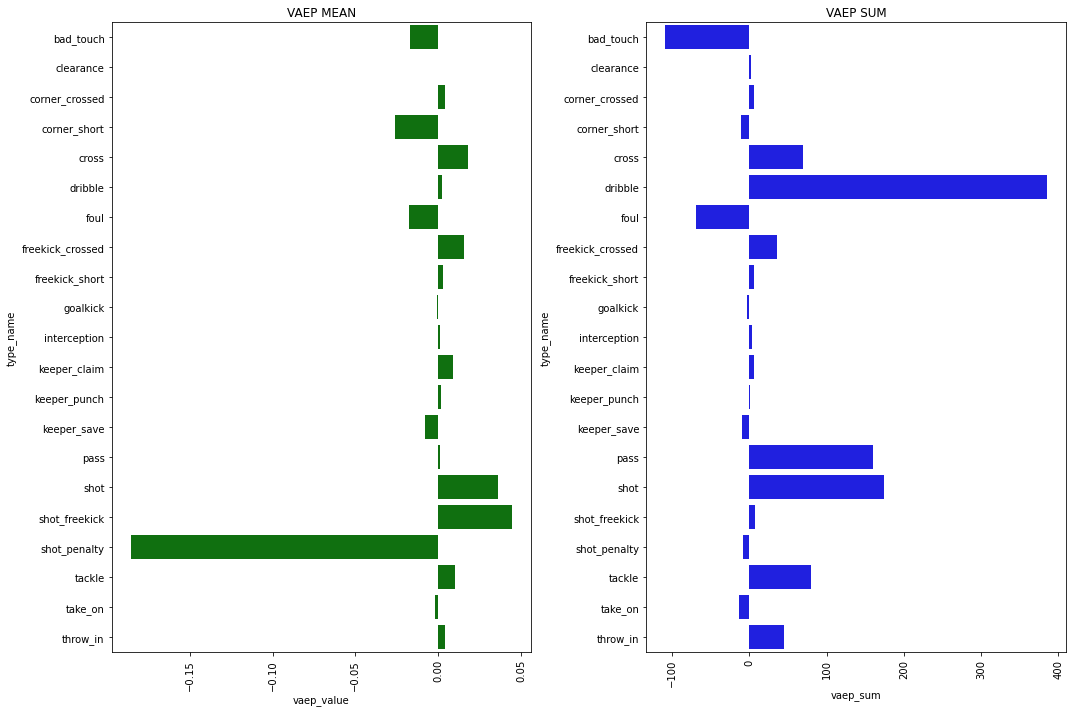

In [49]:
plt.subplots(2,1, figsize=(15,10))

plt.subplot(1,2,1)
sns.barplot(y=action_vaep['type_name'], x=action_vaep['vaep_value'], color='green')
plt.xticks(rotation='90')
plt.title('VAEP MEAN')


plt.subplot(1,2,2)
sns.barplot(y=action_vaep['type_name'], x=action_vaep['vaep_sum'], color='blue')
plt.xticks(rotation='90')
plt.title('VAEP SUM')


plt.tight_layout()
plt.show()

In [50]:
df_actions_zones[(df_actions_zones['type_name']=='shot') & (df_actions_zones['result_name']=='success')].head(10)

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,...,n-5_start_y,n-5_end_x,n-5_end_y,n-5_type_name,n-5_type_name_encoded,n-5_result_name,n-5_bodypart_name,n-5_offensive_value,n-5_defensive_value,n-5_vaep_value
138,7298,3f0fc8e9-a09f-480a-9396-132e1ca05ec5,1,346.0,971,4642.0,94.411765,41.316456,105.000000,31.675949,...,24.962025,97.058824,39.594937,dribble,dribble,success,foot,0.130206,0.000160,0.130366
523,7298,13933d30-56e3-4900-b942-0ee01af8ed1f,1,1401.0,971,4647.0,94.411765,37.873418,105.000000,31.331646,...,20.658228,82.941176,30.987342,pass,pass,success,foot,-0.014979,0.000547,-0.014433
1199,7298,3279e6e0-c796-4871-aaaa-75344dc903b8,2,221.0,746,4654.0,100.588235,33.569620,105.000000,33.827848,...,64.556962,60.000000,57.670886,pass,pass,success,foot,0.002472,0.000161,0.002633
1977,7298,12092a46-bc36-4f00-91f6-767ef8601ae1,2,2434.0,746,4643.0,85.588235,29.265823,105.000000,31.159494,...,32.708861,90.882353,19.797468,pass,pass,success,foot,0.014117,0.000647,0.014763
2458,19778,d78b5024-c498-48f3-8979-b72e575ac84b,1,709.0,746,4643.0,102.352941,43.037975,105.000000,30.987342,...,19.797468,3.529412,20.658228,dribble,dribble,success,foot,0.000665,-0.000131,0.000534
5565,19771,f4d2311a-c176-4761-8e13-5cc626fb490f,2,291.0,969,15562.0,97.058824,42.177215,104.117647,31.331646,...,38.734177,55.588235,38.734177,dribble,dribble,success,foot,-0.002687,-0.000322,-0.003009
6465,19771,efa573c6-1cca-4c51-8e46-f848fa1b5c72,2,2852.0,970,15716.0,98.823529,34.430380,105.000000,32.020253,...,20.658228,87.352941,18.075949,dribble,dribble,success,foot,0.008537,0.000381,0.008918
7330,19736,f31721b3-2495-4f8b-aa4d-948889c5dfe7,1,2225.0,968,15623.0,90.882353,39.594937,104.117647,35.893671,...,41.316456,53.823529,50.784810,pass,pass,success,foot,0.004563,0.002244,0.006808
7601,19736,06aa93ad-015e-4cac-ae32-745276b4d5cf,2,389.0,968,10192.0,91.764706,9.468354,105.000000,37.701266,...,65.417722,37.941176,65.417722,tackle,other,success,foot,0.001916,0.007318,0.009234
7692,19736,e78e001b-34e4-49d4-bf41-ae8f83a13b95,2,695.0,968,15623.0,98.823529,37.012658,104.117647,30.987342,...,36.151899,100.588235,36.496203,shot,other,fail,foot,-0.273133,-0.001531,-0.274664


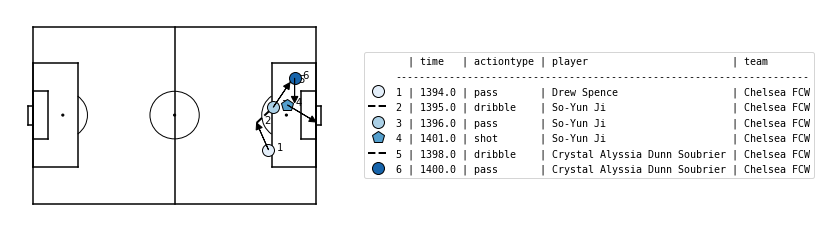

In [51]:
# Select relevant actions
df_actions_goal = df_actions_zones.loc[523 - 5: 523]
# # Replace result, actiontype and bodypart IDs by their corresponding name
# df_actions_goal = spadl.add_names(df_actions_goal)
# Add team and player names
df_actions_goal = df_actions_goal.merge(df_teams).merge(df_players)
# Create the plot
mps.actions(
    location=df_actions_goal[["start_x", "start_y", "end_x", "end_y"]],
    action_type=df_actions_goal.type_name,
    team=df_actions_goal.team_name,
    result=df_actions_goal.result_name == "success",
    label=df_actions_goal[["time_seconds", "type_name", "player_name", "team_name"]],
    labeltitle=["time", "actiontype", "player", "team"],
    zoom=False
)

#### Obserservations on VAEP and Action Type

- passes and dribbles have fairly small average scores - however, this is due to volume, when looking at the sum of those, we see greater contribution 
- here we get to see the high value of less frequent actions such as freekicks 

In [52]:
df_actions_zones.groupby('end_pitch_zone').describe()['x_dif'].reset_index()

,end_pitch_zone,count,mean,std,min,25%,50%,75%,max
0,zone_1,33741.0,1.177404,8.578404,-50.294118,-1.764706,0.000000,5.294118,34.411765
1,zone_2,40266.0,-1.158316,9.129341,-61.764706,-4.411765,0.000000,3.264706,32.647059
2,zone_3,35271.0,1.080875,8.505854,-51.176471,-1.764706,0.000000,5.294118,34.323529
3,zone_4,59776.0,5.739064,12.604037,-61.764706,0.000000,1.588235,10.411765,64.852941
4,zone_5,42529.0,4.183592,12.009782,-47.647059,-0.882353,0.882353,7.941176,67.058824
5,zone_6,57249.0,5.552102,12.394690,-43.235294,-0.352941,1.235294,10.411765,67.058824
6,zone_7,39257.0,8.618291,14.836832,-33.529412,0.000000,3.176471,13.235294,97.058824
7,zone_8,34039.0,8.116991,13.384676,-31.500000,0.000000,3.529412,13.235294,93.529412
8,zone_9,33390.0,8.699318,15.144503,-31.764706,0.000000,3.000000,14.117647,99.705882


In [53]:
zone_values = pd.concat([zone_values, df_actions_zones.groupby('end_pitch_zone').describe()['x_dif'].reset_index().drop(columns=['end_pitch_zone'])], axis=1)

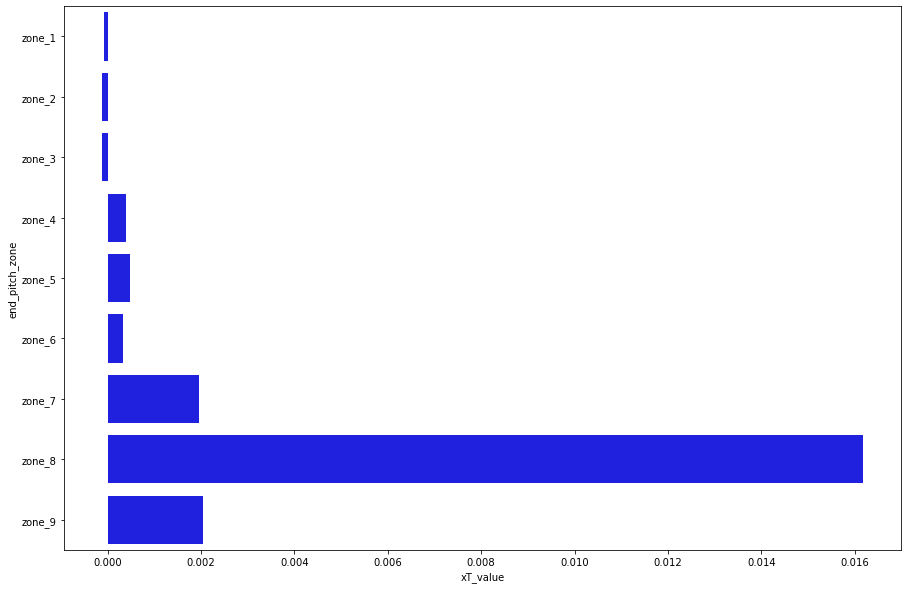

In [54]:
plt.figure(figsize=(15,10))
sns.barplot(y=zone_values['end_pitch_zone'], x=zone_values['xT_value'], color='blue')
plt.show()

#### Observations on xT Value and Pitch Zone

- Zone 8 has the largest mean xT score, which is to be expected as this is where the goal is and therefore it's likely to have more shots and goals from those positions 
- Zones 7 & 9 are the flanks around zone 8 therefore crosses and dangerous passes will come from and into those zones then leading to shots

In [55]:
player_end_zone_counts = df_actions_zones.groupby('player_id')[['end_pitch_zone', 'type_name', 'opponent_id','team_id', 'period_id']].value_counts().reset_index()

In [56]:
player_end_zone_counts.rename(columns={0:'count'}, inplace=True)

In [57]:
top_zone_players = player_end_zone_counts[(player_end_zone_counts['end_pitch_zone']=='zone_8')].sort_values(by='count', ascending=False)

In [58]:
top_vaep_players = list(df_actions_zones.groupby('player_id')['vaep_value'].sum().sort_values(ascending=False).reset_index()['player_id'])

In [59]:
df_actions_zones[(df_actions_zones['player_id'] == 4640) & (df_actions_zones['end_pitch_zone'] == 'zone_8')]

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,...,n-5_start_y,n-5_end_x,n-5_end_y,n-5_type_name,n-5_type_name_encoded,n-5_result_name,n-5_bodypart_name,n-5_offensive_value,n-5_defensive_value,n-5_vaep_value
43439,19785,3467ddfd-0355-4e38-99ab-f5682f5b4fd1,2,2009.0,971,4640.0,5.294118,6.025316,77.647059,37.012658,...,61.974684,91.764706,58.531646,pass,pass,fail,foot,-0.012391,-0.000443,-0.012834
102730,19720,d8bdc0a8-c53c-4bc5-a395-123469e9ad5b,2,2884.0,971,4640.0,45.000000,37.873418,75.882353,39.594937,...,34.430380,8.823529,42.177215,clearance,other,success,foot,-0.000839,-0.005431,-0.006270
114902,19714,8d421222-db9f-47cc-9810-78a77975637b,2,2512.0,971,4640.0,26.470588,40.455696,83.823529,42.177215,...,17.215190,60.000000,17.215190,dribble,dribble,success,foot,0.000551,-0.000626,-0.000074
137048,19776,08c99a61-cff6-4452-b886-363ea784e465,2,759.0,971,4640.0,11.470588,32.708861,91.764706,36.151899,...,57.670886,38.823529,55.949367,dribble,dribble,success,foot,-0.000408,-0.000895,-0.001303


In [60]:
players[players.player_id.isin(top_vaep_players)].drop_duplicates(subset=['player_name']).head(10)

,game_id,team_id,player_id,player_name,nickname,jersey_number,is_starter,starting_position_id,starting_position_name,minutes_played
0,7298,971,4633,Magdalena Lilly Eriksson,None,16,True,5,Left Center Back,97
1,7298,971,4636,Maria Thorisdottir,None,2,False,0,Substitute,12
2,7298,971,4638,Drew Spence,None,24,True,15,Left Center Midfield,58
3,7298,971,4640,Rut Hedvig Lindahl,Hedvig Lindahl,1,True,1,Goalkeeper,97
4,7298,971,4641,Francesca Kirby,None,14,True,22,Right Center Forward,85
5,7298,971,4642,Millie Bright,None,4,True,3,Right Center Back,97
6,7298,971,4647,So-Yun Ji,Ji So-yun,10,True,14,Center Midfield,97
7,7298,971,4657,Anita Amma Ankyewah Asante,Anita Asante,6,True,4,Center Back,97
8,7298,971,4659,Ramona Bachmann,None,23,True,24,Left Center Forward,94
9,7298,971,4660,Erin Cuthbert,None,22,False,0,Substitute,39


In [61]:
players[players.player_id.isin(top_zone_players['player_id'])].drop_duplicates(subset=['player_name'])[['player_id', 'player_name', 'starting_position_name']].head(10)


,player_id,player_name,starting_position_name
0,4633,Magdalena Lilly Eriksson,Left Center Back
1,4636,Maria Thorisdottir,Substitute
2,4638,Drew Spence,Left Center Midfield
3,4640,Rut Hedvig Lindahl,Goalkeeper
4,4641,Francesca Kirby,Right Center Forward
5,4642,Millie Bright,Right Center Back
6,4647,So-Yun Ji,Center Midfield
7,4657,Anita Amma Ankyewah Asante,Center Back
8,4659,Ramona Bachmann,Left Center Forward
9,4660,Erin Cuthbert,Substitute


In [62]:
df_actions_zones['n-1_same_team'].value_counts()

True     294689
False     80829
Name: n-1_same_team, dtype: int64

In [63]:
# #prior moves
# for n in range(1,6):
#     df_actions_zones[f'n-{n}_x_distance'] = [row['x_dif'] for i, row in df_actions_zones.shift(n, axi).iterrows()]
#     df_actions_zones[f'n-{n}_y_distance'] = [row['y_dif'] for i, row in df_actions_zones.shift(n).iterrows()]
#     df_actions_zones[f'n-{n}_same_team'] = df_actions_zones.team_id.eq(df_actions_zones.team_id.shift(n))
#     df_actions_zones[f'n-{n}_same_player'] = df_actions_zones.player_id.eq(df_actions_zones.player_id.shift(n))
#     df_actions_zones[f'n-{n}_x_fwd_direction'] = [1 if row['x_dif'] > 0 else 0 for i, row in df_actions_zones.shift(n).iterrows()]
#     df_actions_zones[f'n-{n}_y_lft_right_direction'] = [1 if row['y_dif'] > 0 else 0 for i, row in df_actions_zones.shift(n).iterrows()]
#     df_actions_zones[f'n-{n}_start_pitch_zone'] = [row['start_pitch_zone'] for i, row in df_actions_zones.shift(n).iterrows()]
#     df_actions_zones[f'n-{n}_end_pitch_zone'] = [row['end_pitch_zone'] for i, row in df_actions_zones.shift(n).iterrows()]
#     df_actions_zones[f'n-{n}_start_x'] = [row['start_x'] for i, row in df_actions_zones.shift(n).iterrows()]
#     df_actions_zones[f'n-{n}_start_y'] = [row['start_y'] for i, row in df_actions_zones.shift(n).iterrows()]
#     df_actions_zones[f'n-{n}_end_x'] = [row['end_x'] for i, row in df_actions_zones.shift(n).iterrows()]
#     df_actions_zones[f'n-{n}_end_y'] = [row['end_y'] for i, row in df_actions_zones.shift(n).iterrows()]
#     df_actions_zones[f'n-{n}_type_id'] = [row['type_id'] for i, row in df_actions_zones.shift(n).iterrows()]
#     df_actions_zones[f'n-{n}_result_id'] = [row['result_id'] for i, row in df_actions_zones.shift(n).iterrows()] 
#     df_actions_zones[f'n-{n}_bodypart_id'] = [row['bodypart_id'] for i, row in df_actions_zones.shift(n).iterrows()]

In [64]:
#We're working with a wide dataset, and may wish to view all columns when reviewing a dataframe
pd.set_option("display.max_rows", None, "display.max_columns", None)

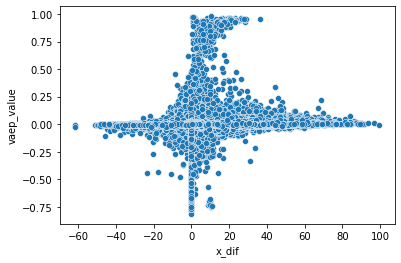

In [65]:
plt.figure()
sns.scatterplot(data=df_actions_zones, x='x_dif', y='vaep_value')
plt.show()

In [66]:
# plt.figure()
# sns.histplot(data=df_actions_zones, x='x_dif', y='vaep_value')
# plt.show()

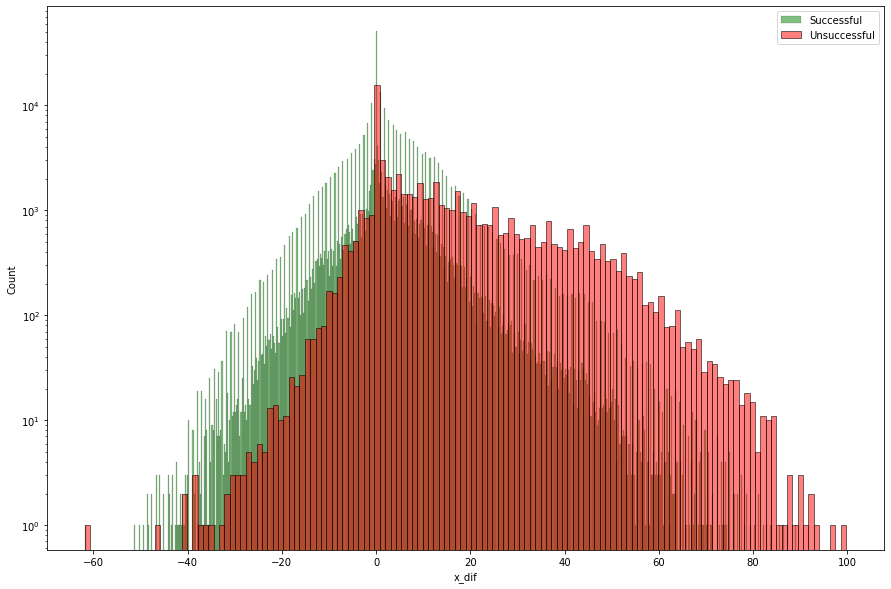

In [67]:
plt.figure(figsize=(15,10))
sns.histplot(df_actions_zones[df_actions_zones['result_name'] == 'success']['x_dif'], alpha=0.5, color='green', label='Successful')
sns.histplot(df_actions_zones[df_actions_zones['result_name'] != 'success']['x_dif'], alpha=0.5, color='red', label = 'Unsuccessful')

plt.yscale('log')
plt.legend()
plt.show()

#### Observations on successful moves and their length and direction

- Successful moves are shorter and backwards with a greater frequency
- Unsuccessful moves tend to be longer and with a forward direction - likely due to the riskier nature of those moves

In [68]:
heatmap_data =df_actions_zones[['end_pitch_zone', 'type_name']].value_counts().reset_index()

In [69]:
heatmap_data.rename(columns={0:'count'}, inplace=True)

In [70]:
heatmap_data = heatmap_data.pivot('end_pitch_zone', 'type_name', 'count')

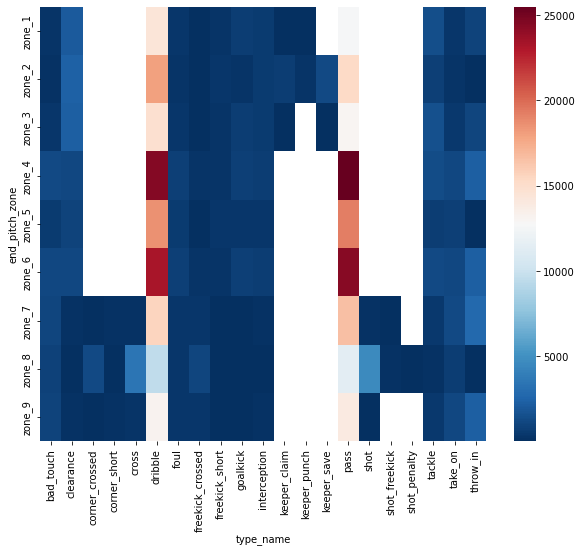

In [71]:
plt.figure(figsize=(10,8))
sns.heatmap(heatmap_data, cmap='RdBu_r')
plt.show()

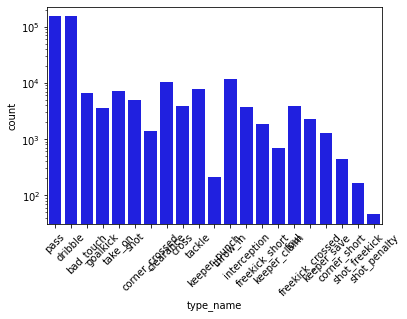

In [72]:
plt.figure()
sns.countplot(df_actions_zones['type_name'], color='blue')
plt.xticks(rotation=45)
plt.yscale('log')
plt.show()

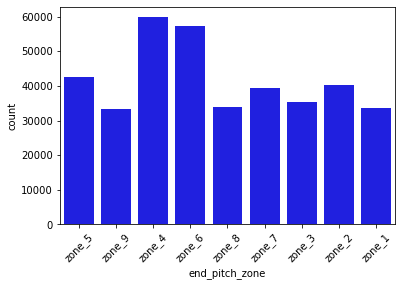

In [73]:
plt.figure()
sns.countplot(df_actions_zones['end_pitch_zone'], color='blue')
plt.xticks(rotation=45)
plt.show()

#### Observations on end zone and action type

- Passes and Dribbles are the most important moves in moving the ball about 
- Will focus the analysis on those 

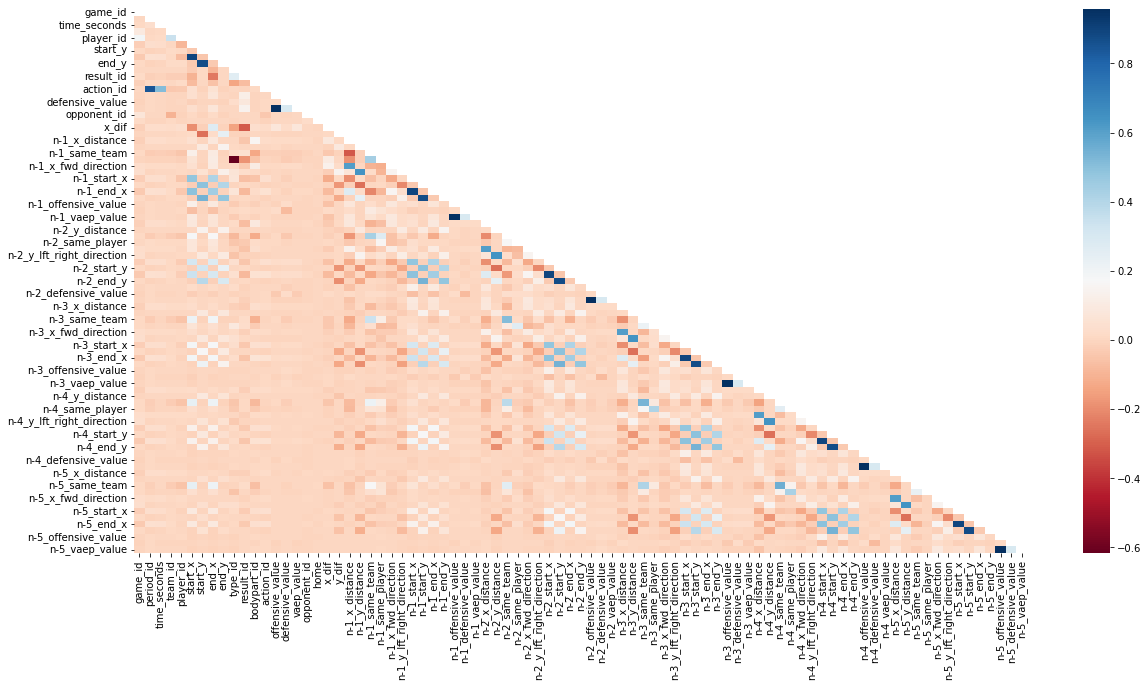

In [74]:
# find the correlation between the variables
corr = df_actions_zones.corr()

# plot the correlation matrix using a heatmap
plt.figure(figsize=(20,10))
matrix = np.triu(corr)
sns.heatmap(corr, mask=matrix, cmap='RdBu')
plt.show()